# Projet d'analyse de fraude

Par Théo DESLAGE et Maximilien GOMAS

## Exploration et visualisation des données

On peut constater que les données sont divisées en deux ensembles :
- Le premier, labelisé, servira à l'apprentissage supervisé (Entrainement et test)
- Le second, inconnu, représente une situation réelle dans laquelle nous devrons prédire à l'aide de notre modèle

Chargeons les données

In [49]:
fraudes <- read.csv("./data/Data_Projet_1.csv", header = TRUE, sep = ",", dec = ".", stringsAsFactors = TRUE)
head(fraudes)

,claim_id,customer_id,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
,<int>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>
1,54004764,21868593,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,No
2,33985796,75740424,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,No
3,53522022,30308357,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,Yes
4,13015401,47830476,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
5,22890252,19269962,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No
6,24050443,21831191,36,Male,Other driver error,2116,Auto,No,Injury only,38306.5,3,Yes


Nous allons maintenant explorer les données et comprendre quelles features sont déterminantes pour la prédiction de la fraude.

### Summary pour se donner une vue globale

In [2]:
summary(fraudes)

    claim_id         customer_id            age          gender   
 Min.   :   26832   Min.   :  154557   Min.   :18.0   Female:541  
 1st Qu.:23815805   1st Qu.:26791756   1st Qu.:33.0   Male  :559  
 Median :48539331   Median :49855152   Median :47.0               
 Mean   :48838190   Mean   :50874698   Mean   :47.8               
 3rd Qu.:74074466   3rd Qu.:75949511   3rd Qu.:63.0               
 Max.   :99775483   Max.   :99961993   Max.   :79.0               
            incident_cause days_to_incident  claim_area police_report
 Crime             :110    Min.   :    2.0   Auto:985   No     :630  
 Driver error      :262    1st Qu.:  635.5   Home:115   Unknown:300  
 Natural causes    :189    Median : 2042.5              Yes    :170  
 Other causes      :290    Mean   : 2814.1                           
 Other driver error:249    3rd Qu.: 4153.5                           
                           Max.   :14991.0                           
               claim_type   claim_amount 

### Recherche sur l'age

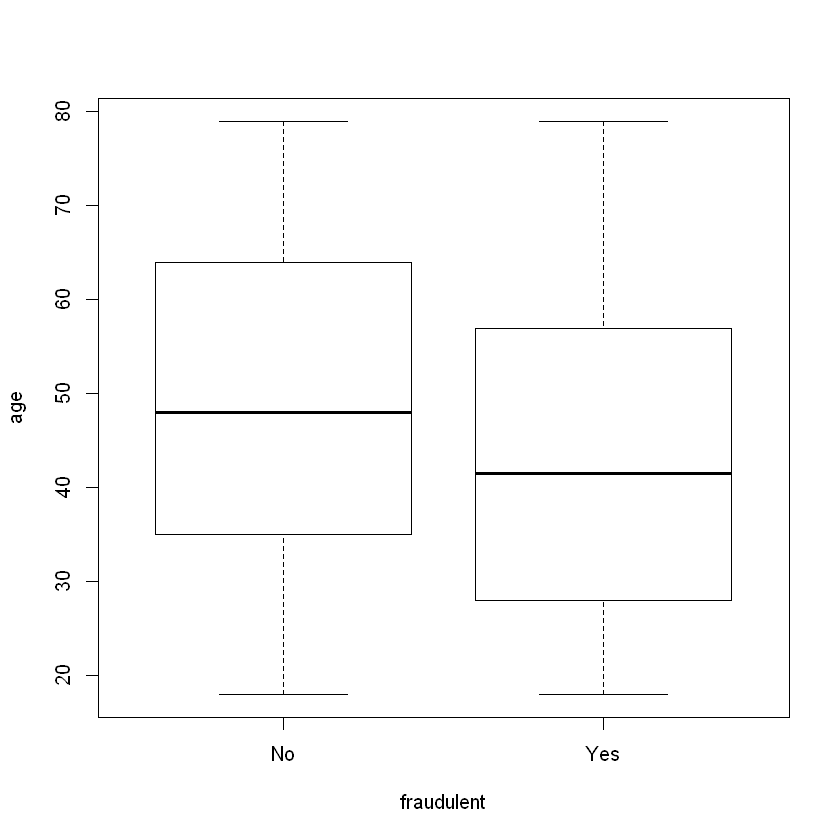

In [3]:
boxplot(age~fraudulent, data=fraudes)

On peut constater que les déclarations frauduleuses concernent un publique plus jeune que celles qui ne le sont pas.

### Recherche par rapport au montant déclaré

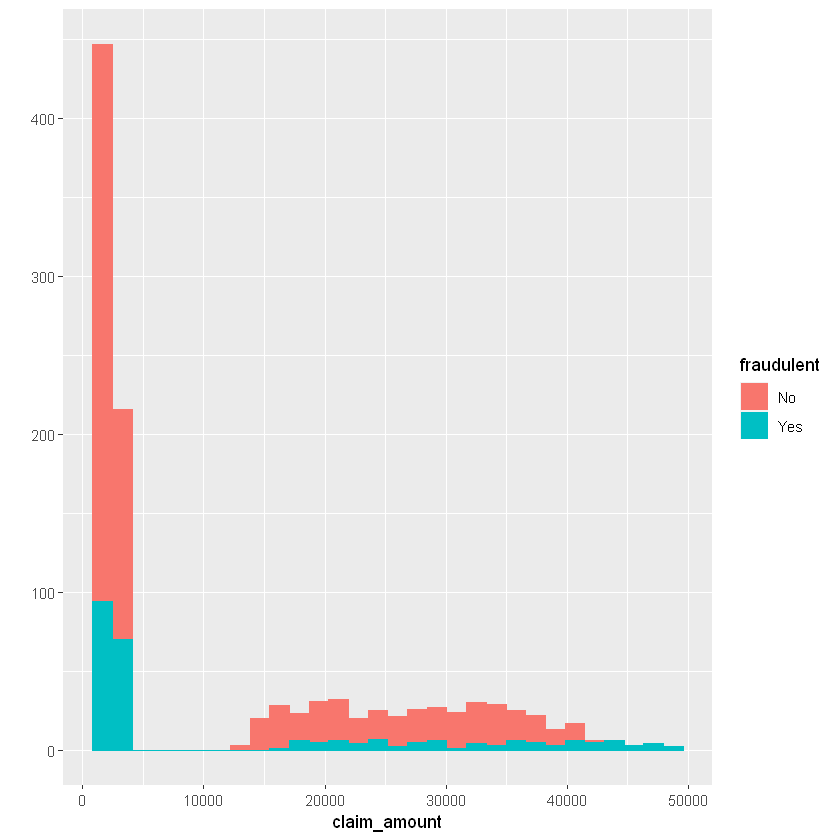

In [4]:
library(ggplot2)
qplot(claim_amount, data=fraudes, color=fraudulent, fill=fraudulent,bins = 30)

On décide de séparer les claim_amount (supérieur et inférieur à 10000) pour mieux visualiser les tendances.

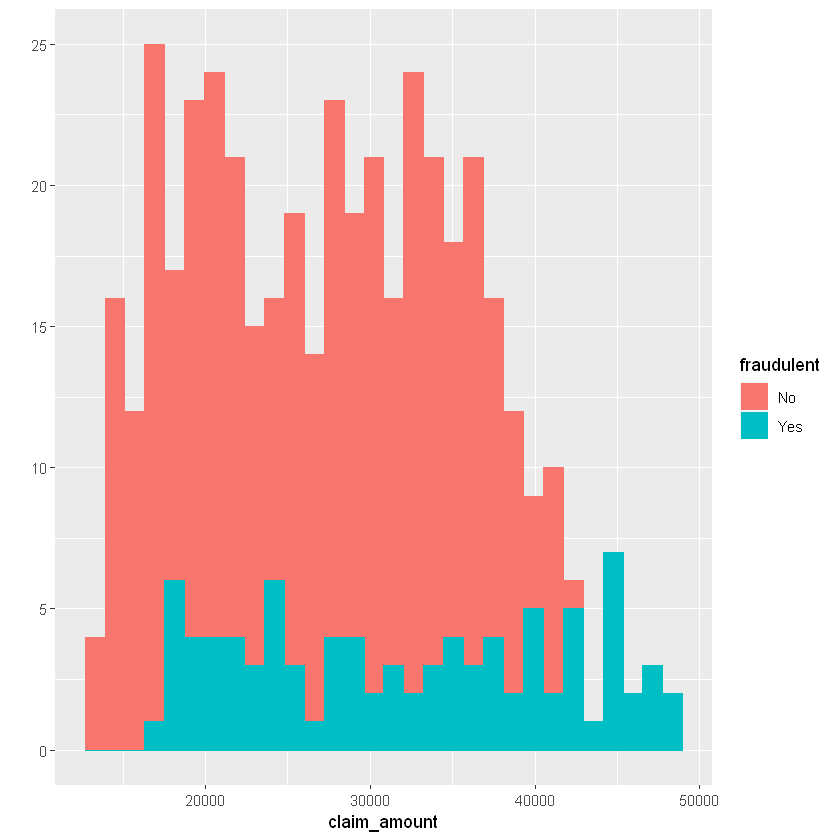

In [5]:
library(ggplot2)
qplot(claim_amount, data=fraudes[fraudes$claim_amount>10000,], color=fraudulent, fill=fraudulent, bins = 30)

On remarque qu'au dessus de 43k, toutes les ransactions sont frauduleuses. Nous décidons d'enlever les valeurs au dessus de 43k lors du pré traitement des données, car notre arbre fera inéluctablement une corrélation qui nous semble plus lié au jeu de donnée qu'à une représentation de la réalité.

Pour confirmer notre raisonnement on compte le nombre de transactions concernées, et on se rend compte que c'est assez faible (15/1100)

In [6]:
nrow(fraudes)
nrow(fraudes[fraudes$claim_amount>43000,])

[1] 1100

[1] 15

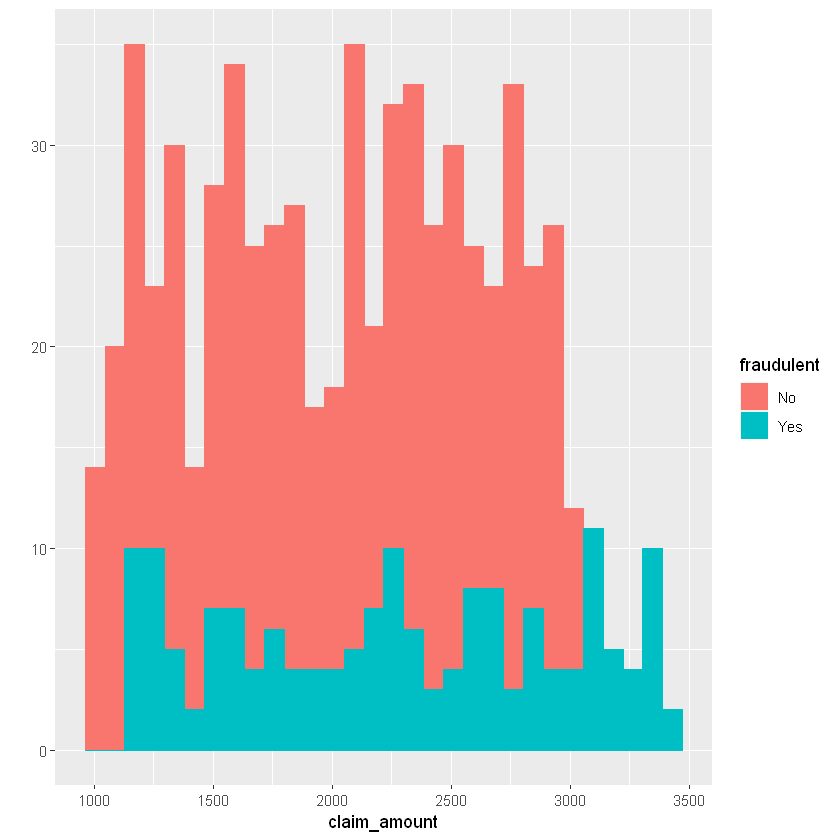

In [7]:
qplot(claim_amount, data=fraudes[fraudes$claim_amount<10000,], color=fraudulent, fill=fraudulent, bins = 30)

### Recherche par rapport au genre

On se permet de comparer car grâce à la summarization on a pu constater que le nombre d'échantillon pour chaque sexe était relativement le même.

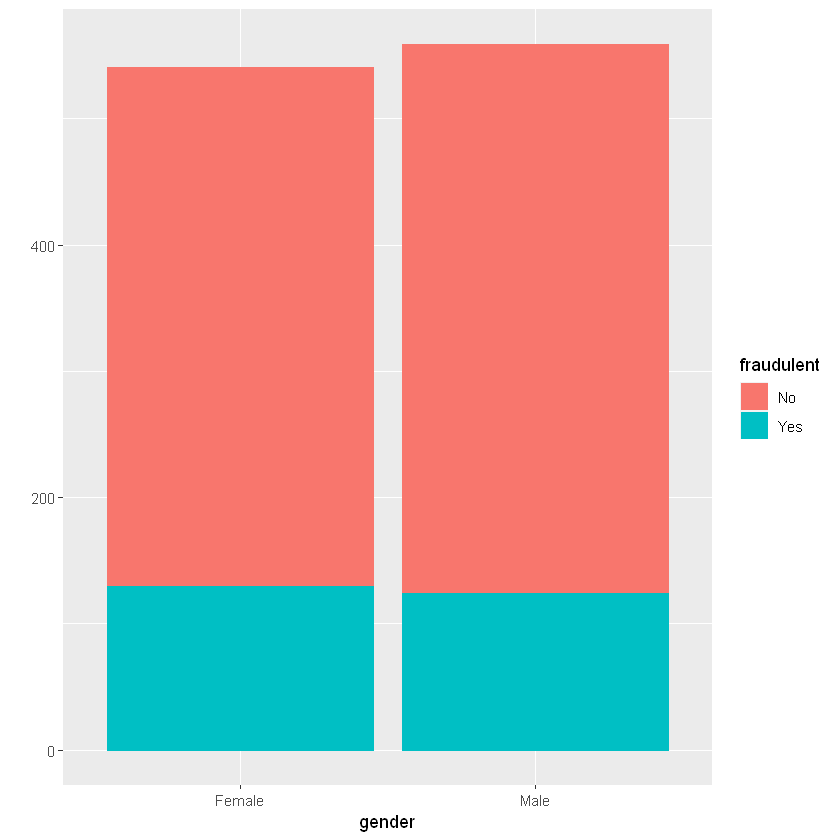

In [8]:
qplot(gender, data=fraudes, color=fraudulent, fill=fraudulent)

On constate que le genre n'influe pas du tout sur le caractère frauduleux d'une transaction

### La cause de l'incident

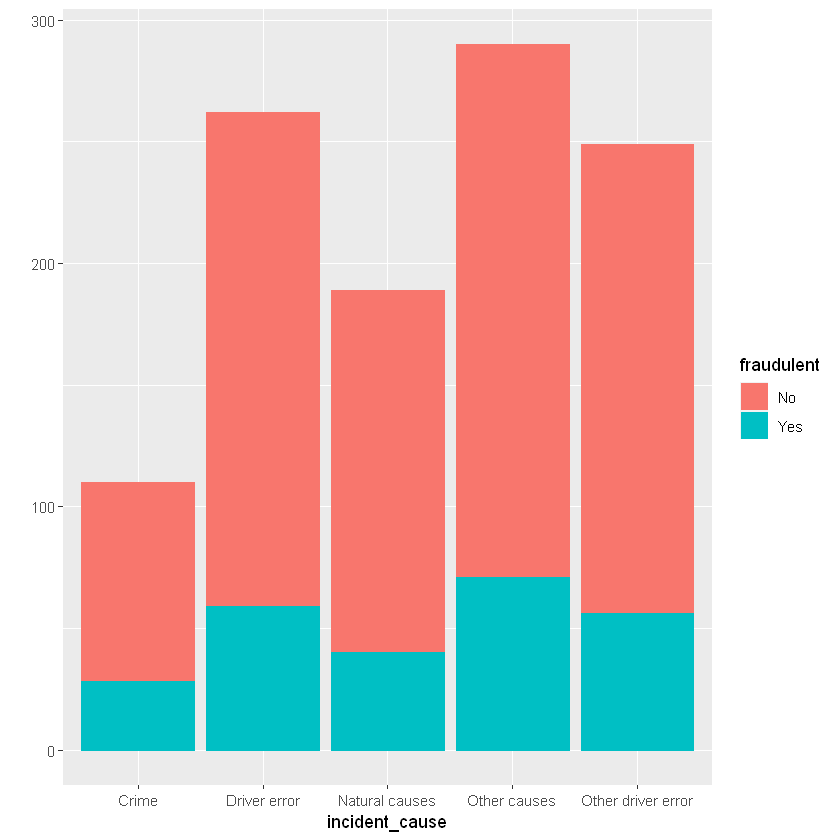

In [9]:
qplot(incident_cause, data=fraudes, color=fraudulent, fill=fraudulent)

On constate que la cause de l'incident ne joue pas beaucoup non plus sur le caractère frauduleux

### Nombre de jours passés entre l'incident et la déclaration

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



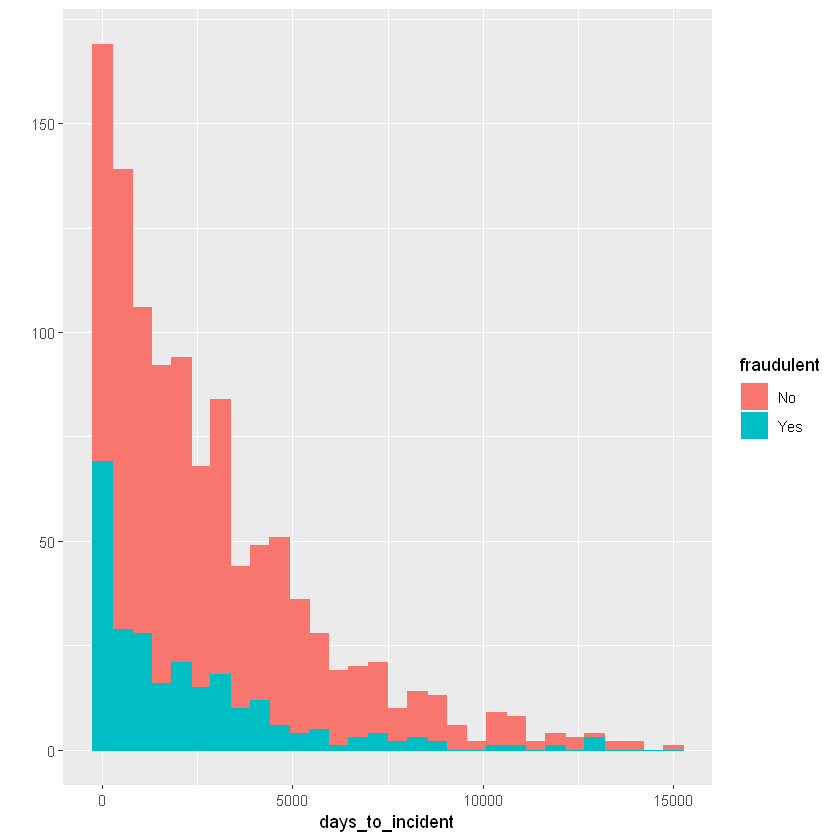

In [10]:
qplot(days_to_incident, data=fraudes, color=fraudulent, fill=fraudulent)

On remarque qu'il y a une proportion de fraudes plus élevée pour les incidents déclarés immédiatements. On confirme :

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



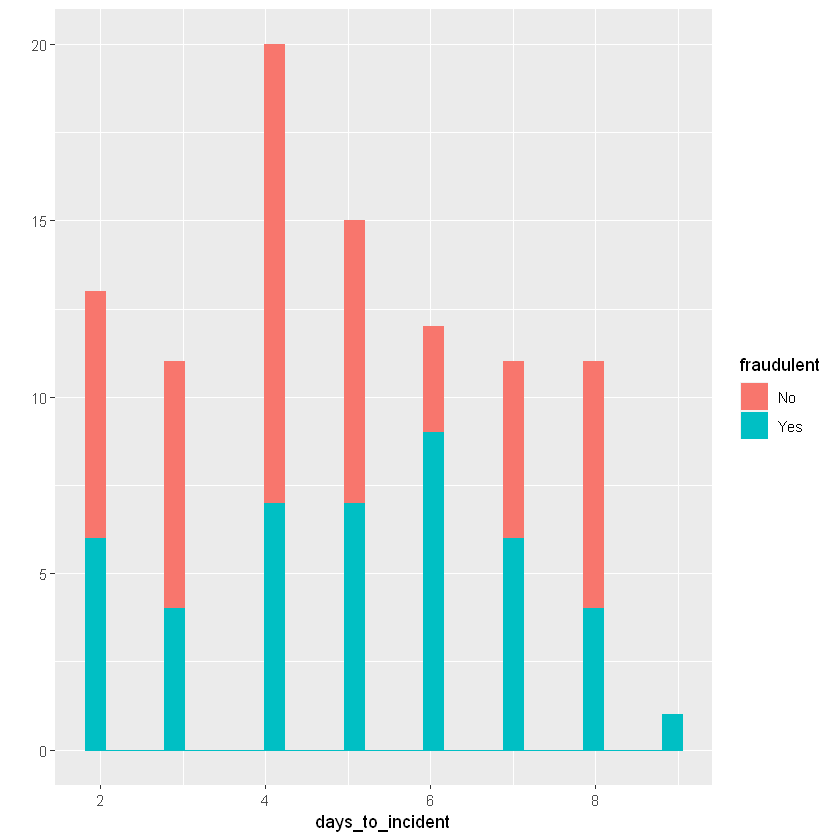

In [11]:
qplot(days_to_incident, data=fraudes[fraudes$days_to_incident<10,], color=fraudulent, fill=fraudulent)

In [12]:
print(nrow(fraudes[fraudes$days_to_incident<10 & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$days_to_incident<10,]))
print(nrow(fraudes[fraudes$fraudulent=='Yes',])/nrow(fraudes))

[1] 0.4680851
[1] 0.2309091


Cela veut dire que pour des déclarations faites à moins de 10 jours on a 46% de fraude ce qui est nettement superieur à l'ensemble global (23%). Ce critère sera donc très intéressant pour notre modèle.

### La zone de déclaration

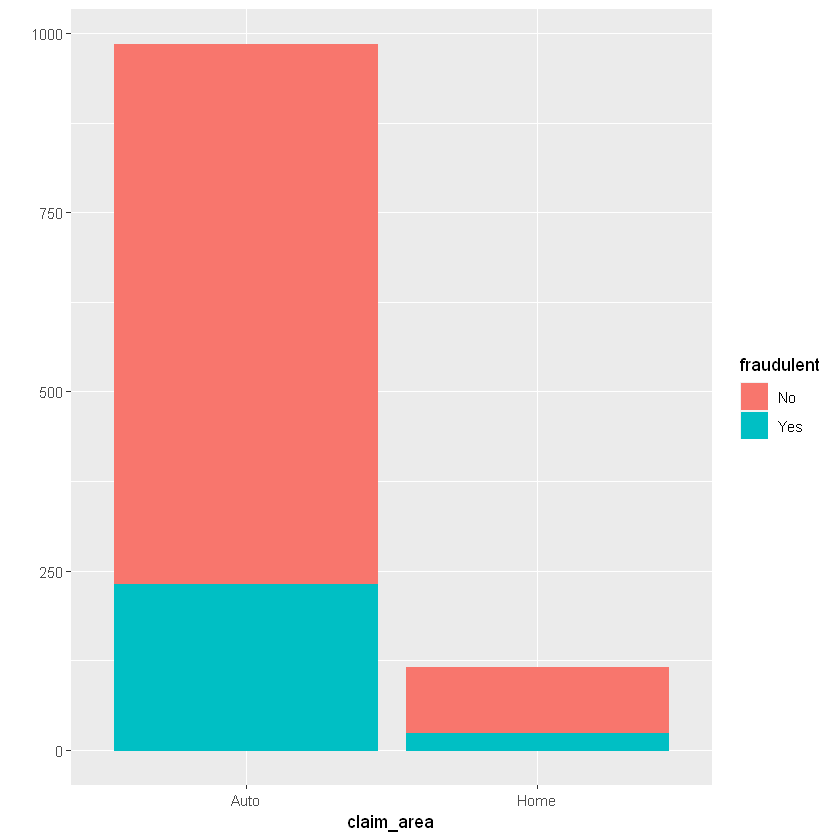

In [13]:
qplot(claim_area, data=fraudes, color=fraudulent, fill=fraudulent)

### Un rapport de police

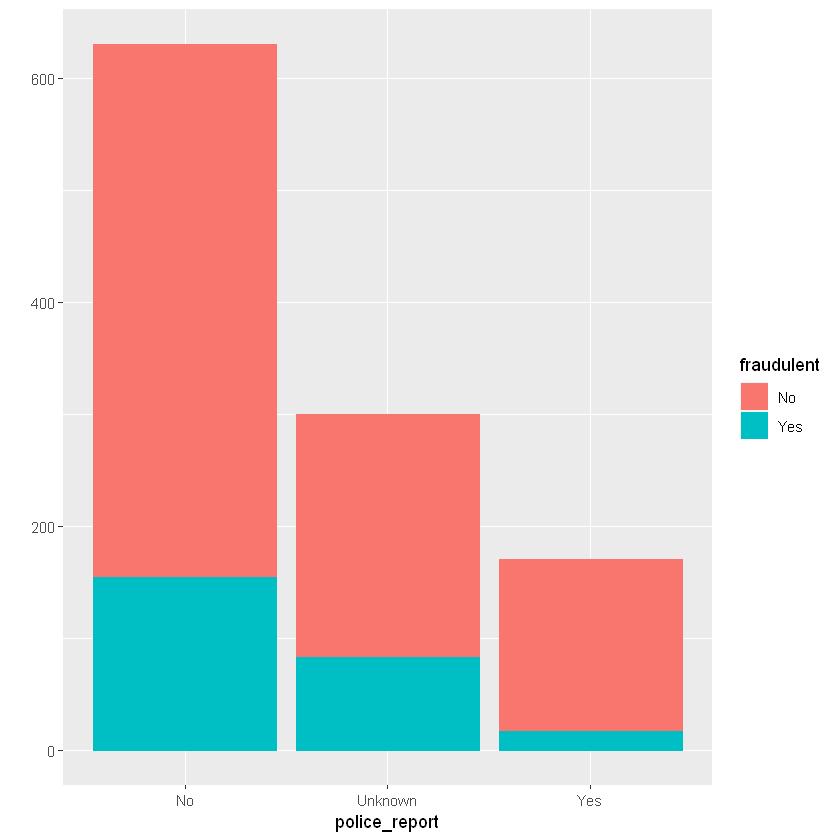

In [14]:
qplot(police_report, data=fraudes, color=fraudulent, fill=fraudulent)

On présent une information intéressante, on compare donc les 3 cas (avec le global qui est de 23%)

In [15]:
print(nrow(fraudes[fraudes$police_report=='Yes' & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$police_report=='Yes',])) # Rapport
print(nrow(fraudes[fraudes$police_report=='Unknown' & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$police_report=='Unknown',])) # Unknown
print(nrow(fraudes[fraudes$police_report=='No' & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$police_report=='No',])) # No Report

[1] 0.1
[1] 0.2766667
[1] 0.2444444


On constate que lors de la réalisation d'un rapport il n'y a que 10% de fraudes, ça influe donc très négativement (positivement pour l'assureur) sur les fraudes.

### Le type de déclaration

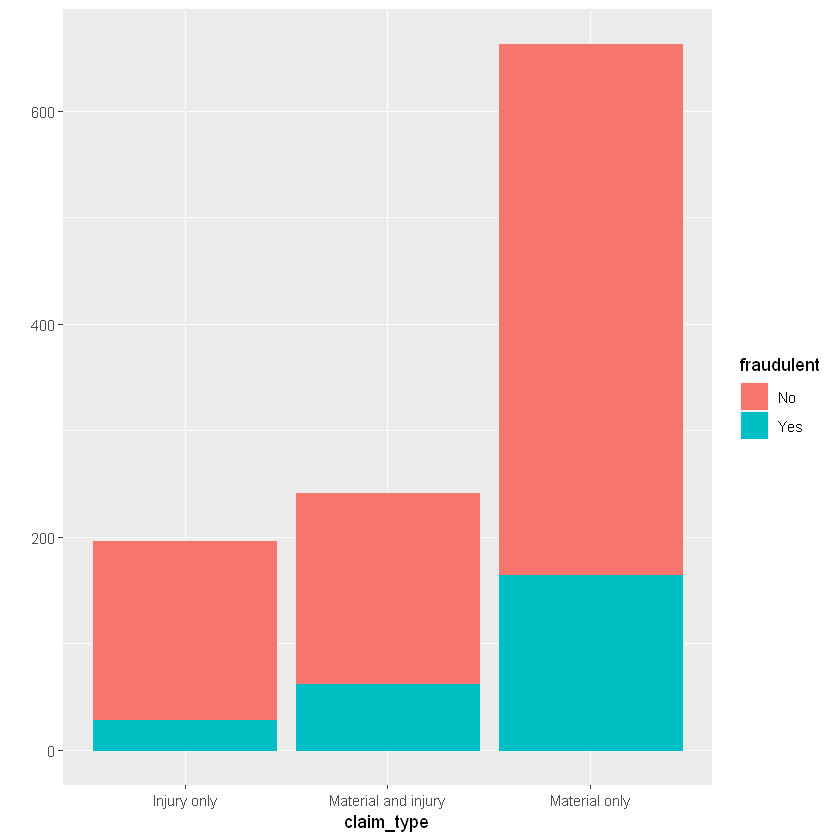

In [16]:
qplot(claim_type, data=fraudes, color=fraudulent, fill=fraudulent)

### Nombre d'incidents déclarés

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



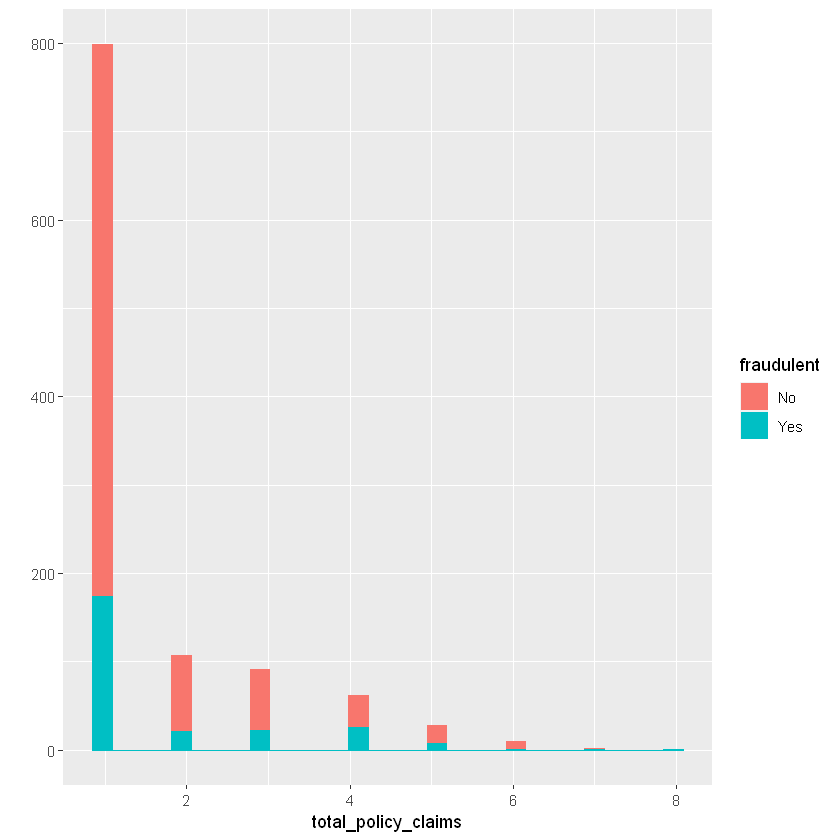

In [17]:
qplot(total_policy_claims, data=fraudes, color=fraudulent, fill=fraudulent) 

In [18]:
print(nrow(fraudes[fraudes$total_policy_claims==2 & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$total_policy_claims==2,])) 
nrow(fraudes[fraudes$total_policy_claims==1,])

for (x in 1:8) {
    print("------")
    print(nrow(fraudes[fraudes$total_policy_claims==x,]))
    pct <- nrow(fraudes[fraudes$total_policy_claims==x & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$total_policy_claims==x,])*100
    print(pct)
} 

[1] 0.1962617


[1] 799

[1] "------"
[1] 799
[1] 21.77722
[1] "------"
[1] 107
[1] 19.62617
[1] "------"
[1] 91
[1] 24.17582
[1] "------"
[1] 62
[1] 41.93548
[1] "------"
[1] 28
[1] 28.57143
[1] "------"
[1] 10
[1] 10
[1] "------"
[1] 2
[1] 50
[1] "------"
[1] 1
[1] 100


In [19]:
print(fraudes[fraudes$total_policy_claims>6,])

    claim_id customer_id age gender     incident_cause days_to_incident
52  39647651    18361978  73 Female       Other causes             4770
820 42530425    46129941  29 Female              Crime             1274
875 32759962    77116501  68 Female Other driver error             2820
    claim_area police_report          claim_type claim_amount
52        Auto       Unknown Material and injury      25576.0
820       Auto            No       Material only       3277.5
875       Auto       Unknown         Injury only      20490.0
    total_policy_claims fraudulent
52                    7        Yes
820                   8        Yes
875                   7         No


Il n'y a que très peu de données pour les policy claims == 7 ou 8, on décidera donc de les enlever

## Pré traitement des données

On sait que deux variables ne sont pas pertinentes dans la prédiction, l'ID de la transaction *claim_id* puisqu'il est unique et le numéro d'utilisateur *customer_id*. On pourrait établir un modèle qui prend en compte le *customer_id* pour "suspecter" ceux qui ont déjà fraudé. Mais dans ce cas de la détection de nouvelles fraudes l'utilisateur sera très probablement nouveau, il ne faut pas que cela altère le jugement du modèle, qui doit se méfier de tout le monde, sans distinction.

In [58]:
# On essaye de réaliser l'arbre avec les features que nous avons trouvé pertinentes
featuresPertinentes <- c('age', 'claim_amount', 'days_to_incident', 'police_report', 'total_policy_claims', 'fraudulent')

# On filtre selon ce qu'on avait décidé sur le claim_amount
fraudes <- fraudes[fraudes$claim_amount<43000,]
# On supprime le claim_id et le customer_id
fraudes <- fraudes[,-c(1:2)]
head(fraudes)


,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>
4,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
5,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No
6,36,Male,Other driver error,2116,Auto,No,Injury only,38306.5,3,Yes
7,73,Male,Driver error,4196,Auto,No,Material only,1730.0,4,No
8,55,Male,Natural causes,622,Auto,No,Material only,1160.0,3,No
9,67,Male,Crime,3386,Auto,Unknown,Material only,2620.0,1,No


## Définition de la méthode d'évaluation des classifieurs

Nous allons utiliser les 3 arbres vus en cours (tree, C5.0 et rpart) et nous allons essayer avec toutes les features, puis seulement avec celles que nous pensons pertinentes.

fraudes -> toutes

fraudesP -> seulement celles pertinentes

## Définition des données d'apprentissage et de test

In [71]:
# First 400 rows (2/3) apprentissage
fraudes_EA <- fraudes[1:730,-1]
fraudesP_EA <- fraudes[1:400,featuresPertinentes]

# Last 200 rows (1/3) test
fraudes_ET <- fraudes[730:1082,-1]
fraudesP_ET <- fraudes[401:600,featuresPertinentes]

## Construction et évaluation du classifieur

### Analyse avec toutes les features

In [72]:
library(rpart)
library(C50)
library(tree)

In [73]:
tree1 <- rpart(fraudulent ~ ., fraudes_EA)
tree2 <- C5.0(fraudulent ~ ., fraudes_EA)
tree3 <- tree(fraudulent ~ ., fraudes_EA)

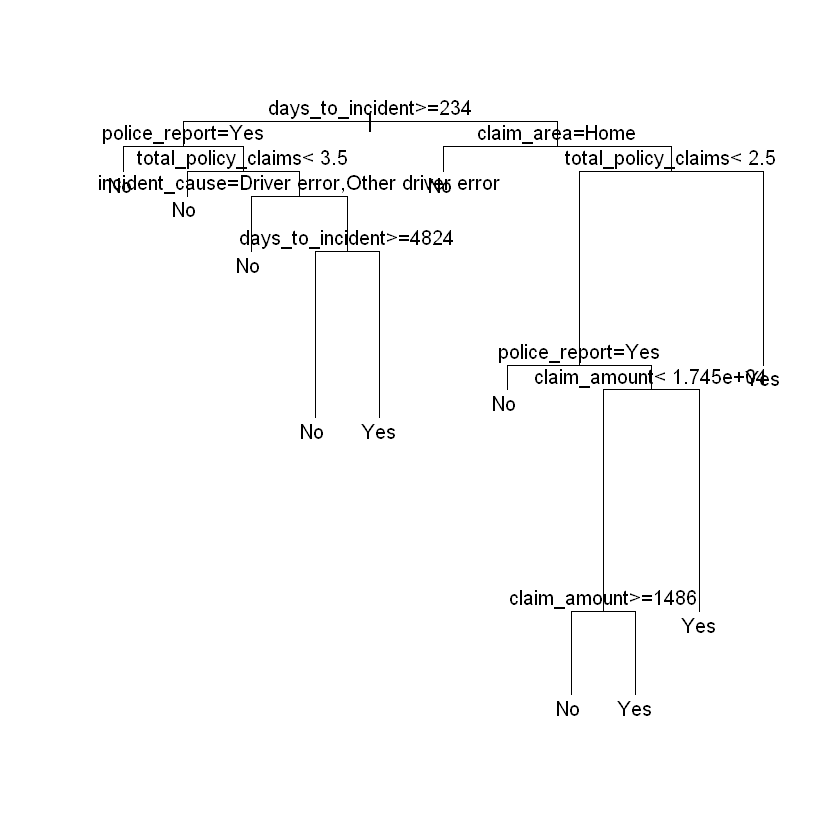

In [74]:
plot(tree1)
text(tree1, pretty=0)

In [75]:
test_tree1 <- predict(tree1, fraudes_ET, type="class")
table(test_tree1)
test_tree2 <- predict(tree2, fraudes_ET, type="class")
table(test_tree2)
test_tree3 <- predict(tree3, fraudes_ET, type="class")
table(test_tree3)

test_tree1
 No Yes 
322  31 

test_tree2
 No Yes 
323  30 

test_tree3
 No Yes 
353   0 

Matrices de confusion

In [91]:
mc_tree1 = table(fraudes_ET$fraudulent, test_tree1)
mc_tree2 = table(fraudes_ET$fraudulent, test_tree2)
mc_tree3 = table(fraudes_ET$fraudulent, test_tree3)
print(mc_tree1)
print(mc_tree2)
print(mc_tree3)

     test_tree1
       No Yes
  No  253  20
  Yes  69  11
     test_tree2
       No Yes
  No  259  14
  Yes  64  16
     test_tree3
       No Yes
  No  273   0
  Yes  80   0


In [79]:
fraudes_ET$Prediction1 <- test_tree1
fraudes_ET$Prediction2 <- test_tree2
fraudes_ET$Prediction3 <- test_tree3
sample(fraudes_ET, 10)

,Prediction2,claim_type,total_policy_claims,fraudulent,claim_area,police_report,days_to_incident,Prediction1,incident_cause,claim_amount
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<dbl>
743,No,Material only,3,No,Auto,No,2040,No,Driver error,1120.0
744,No,Material and injury,1,No,Auto,No,1455,No,Natural causes,14220.0
745,No,Injury only,1,No,Auto,Yes,1248,No,Other driver error,18650.0
746,Yes,Material only,1,Yes,Auto,No,2396,No,Other driver error,3415.5
747,No,Injury only,1,No,Auto,Yes,2114,No,Other driver error,19400.0
748,No,Material only,1,No,Home,No,6138,No,Driver error,2310.0
749,No,Material and injury,1,Yes,Auto,Unknown,394,No,Other causes,24621.5
750,No,Material only,1,Yes,Auto,No,64,No,Natural causes,3128.0
751,Yes,Material only,1,Yes,Auto,Unknown,103,No,Crime,3369.5


In [90]:
# Success rate

nbr_success <- nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes' & fraudes_ET$Prediction1=='Yes', ])
taux_success1 = nbr_success/nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes',])*100
taux_success1

nbr_success <- nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes' & fraudes_ET$Prediction2=='Yes', ])
taux_success2 = nbr_success/nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes',])*100
taux_success2

nbr_success <- nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes' & fraudes_ET$Prediction3=='Yes', ])
taux_success3 = nbr_success/nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes',])*100
taux_success3

[1] 13.75

[1] 20

[1] 0

## Choix du classifieur le plus performant

## Application du classifieur aux données à prédire

/!\ Il y a (logiquement) beaucoup plus de No que de Yes, vérifier si on ne doit pas corriger ça (mieux répatir...)